In [47]:
import pandas as pd
import numpy as np

In [2]:
male_players = pd.read_csv('data/male_players.csv')
male_players

/var/folders/tm/84lbt1dd25b7bgsx7m5x8wlm0000gn/T/ipykernel_24969/2510204913.py:1: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  male_players = pd.read_csv('data/male_players.csv')


,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,/player/165153/karim-benzema/240002,24.0,2.0,2023-09-22,K. Benzema,Karim Benzema,"CF, ST",90,90,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180016,220806,https://sofifa.com/player/220806/ellis-redman/...,15.0,2.0,2014-09-18,E. Redman,Ellis Redman,CB,41,61,...,38,38,38,37,40,41,41,41,40,10
180017,225509,https://sofifa.com/player/225509/aaron-collins...,15.0,2.0,2014-09-18,A. Collins,Aaron Graham John Collins,ST,41,50,...,30,30,30,31,32,31,31,31,32,14
180018,217591,https://sofifa.com/player/217591/piotr-zemlo/1...,15.0,2.0,2014-09-18,P. Żemło,Piotr Żemło,"LM, LB",40,50,...,46,46,46,48,51-1,53-3,53-3,53-3,51-1,12
180019,222947,https://sofifa.com/player/222947/tom-davies/15...,15.0,2.0,2014-09-18,T. Davies,Thomas Christopher Davies,CB,40,49,...,36,36,36,37,39,40,40,40,39,13


In [3]:
male_players = male_players.drop(['player_url','short_name', 'long_name','potential','value_eur','wage_eur','age','dob','club_team_id','club_name','league_id','league_name','league_level','club_position','club_jersey_number','club_loaned_from','club_joined_date','club_contract_valid_until_year','nationality_id','nationality_name', 'nation_team_id','nation_position','nation_jersey_number','international_reputation','body_type','real_face','release_clause_eur','player_tags','player_traits', 'fifa_update', 'goalkeeping_speed', 'shooting', 'passing', 'physic', 'defending', 'dribbling', 'pace', 'mentality_composure'], axis = 1)
male_players

,player_id,fifa_version,update_as_of,player_positions,overall,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,24.0,2023-09-22,"ST, LW",91,182,75,Right,4,5,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,24.0,2023-09-22,ST,91,195,94,Left,3,3,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,24.0,2023-09-22,"CM, CAM",91,181,75,Right,5,4,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,24.0,2023-09-22,"CF, CAM",90,169,67,Left,4,4,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,24.0,2023-09-22,"CF, ST",90,185,81,Right,4,4,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180016,220806,15.0,2014-09-18,CB,41,187,81,Right,2,2,...,38,38,38,37,40,41,41,41,40,10
180017,225509,15.0,2014-09-18,ST,41,178,57,Right,3,3,...,30,30,30,31,32,31,31,31,32,14
180018,217591,15.0,2014-09-18,"LM, LB",40,190,76,Left,3,2,...,46,46,46,48,51-1,53-3,53-3,53-3,51-1,12
180019,222947,15.0,2014-09-18,CB,40,180,70,Right,2,2,...,36,36,36,37,39,40,40,40,39,13


In [4]:
pd.set_option('display.max_rows', 10)
male_players_24 = male_players[male_players['fifa_version'] == 24.0]
male_players_24 

,player_id,fifa_version,update_as_of,player_positions,overall,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,24.0,2023-09-22,"ST, LW",91,182,75,Right,4,5,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,24.0,2023-09-22,ST,91,195,94,Left,3,3,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,24.0,2023-09-22,"CM, CAM",91,181,75,Right,5,4,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,24.0,2023-09-22,"CF, CAM",90,169,67,Left,4,4,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,24.0,2023-09-22,"CF, ST",90,185,81,Right,4,4,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18345,273759,24.0,2023-09-22,CB,47,176,76,Left,3,2,...,39+2,39+2,39+2,41+2,43+2,47+2,47+2,47+2,43+2,13+2
18346,269013,24.0,2023-09-22,CB,47,183,74,Right,3,2,...,43+2,43+2,43+2,44+2,46+2,47+2,47+2,47+2,46+2,13+2
18347,272748,24.0,2023-09-22,ST,47,184,65,Right,2,2,...,31+2,31+2,31+2,35+2,33+2,27+2,27+2,27+2,33+2,13+2
18348,269534,24.0,2023-09-22,CM,47,178,74,Right,3,2,...,45+2,45+2,45+2,45+2,45+2,44+2,44+2,44+2,45+2,14+2


In [5]:
male_players_24.isna().sum().sort_values(ascending=False)[:10]

player_id    0
st           0
rw           0
rf           0
cf           0
lf           0
lw           0
rs           0
ls           0
cam          0
dtype: int64

In [6]:
missing = male_players.isna().sum()
missing.sort_values(ascending= False)

player_id                0
st                       0
rw                       0
rf                       0
cf                       0
                        ..
movement_agility         0
movement_sprint_speed    0
movement_acceleration    0
skill_ball_control       0
gk                       0
Length: 71, dtype: int64

In [7]:
male_players_24.dtypes[::-1][:10]

gk     object
rb     object
rcb    object
cb     object
lcb    object
lb     object
rwb    object
rdm    object
cdm    object
ldm    object
dtype: object

In [8]:
male_players_24 = male_players_24.copy()

def extract_and_convert(value):
    value = str(value)
    # Split the string at '+', take the first part, and convert to integer
    if pd.isna(value):
        return None  # or return np.nan if you want to keep NaN values
    # Split the string at '+' or '-' and convert to integer
    for char in ['+', '-']:
        if char in value:
            return int(value.split(char)[0])
    # If neither '+' nor '-' is in the value, just convert it to integer
    return int(value)

columns_to_process = ['ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb', 'gk']

for column in columns_to_process:
    male_players_24.loc[:, column] = male_players_24[column].apply(extract_and_convert)

male_players_24

/var/folders/tm/84lbt1dd25b7bgsx7m5x8wlm0000gn/T/ipykernel_24969/1243365755.py:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  male_players_24.loc[:, column] = male_players_24[column].apply(extract_and_convert)


,player_id,fifa_version,update_as_of,player_positions,overall,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,24.0,2023-09-22,"ST, LW",91,182,75,Right,4,5,...,63,63,63,68,63,54,54,54,63,18
1,239085,24.0,2023-09-22,ST,91,195,94,Left,3,3,...,63,63,63,62,60,62,62,62,60,19
2,192985,24.0,2023-09-22,"CM, CAM",91,181,75,Right,5,4,...,80,80,80,79,75,70,70,70,75,21
3,158023,24.0,2023-09-22,"CF, CAM",90,169,67,Left,4,4,...,63,63,63,64,59,49,49,49,59,19
4,165153,24.0,2023-09-22,"CF, ST",90,185,81,Right,4,4,...,64,64,64,64,60,55,55,55,60,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18345,273759,24.0,2023-09-22,CB,47,176,76,Left,3,2,...,39,39,39,41,43,47,47,47,43,13
18346,269013,24.0,2023-09-22,CB,47,183,74,Right,3,2,...,43,43,43,44,46,47,47,47,46,13
18347,272748,24.0,2023-09-22,ST,47,184,65,Right,2,2,...,31,31,31,35,33,27,27,27,33,13
18348,269534,24.0,2023-09-22,CM,47,178,74,Right,3,2,...,45,45,45,45,45,44,44,44,45,14


In [9]:
dt = male_players_24.dtypes
dt.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

/Users/shaysamat/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.4649759660647098


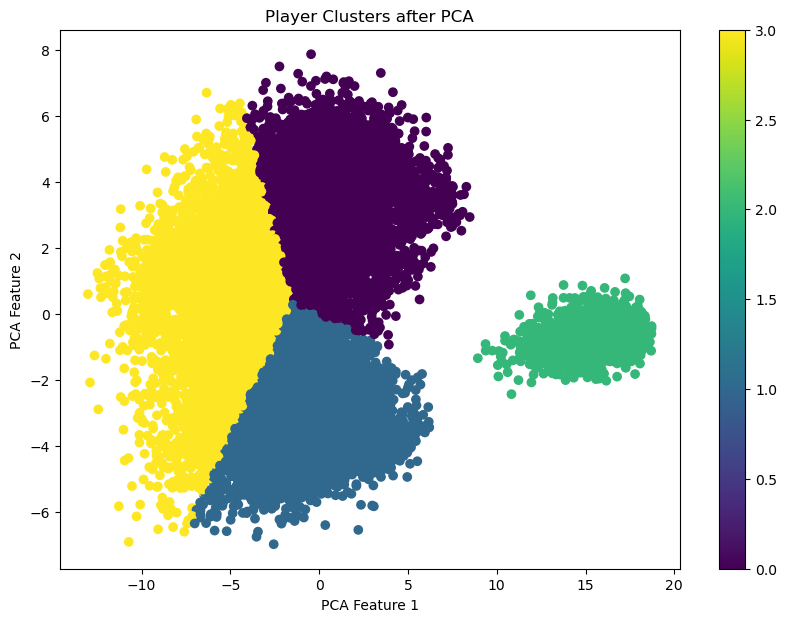

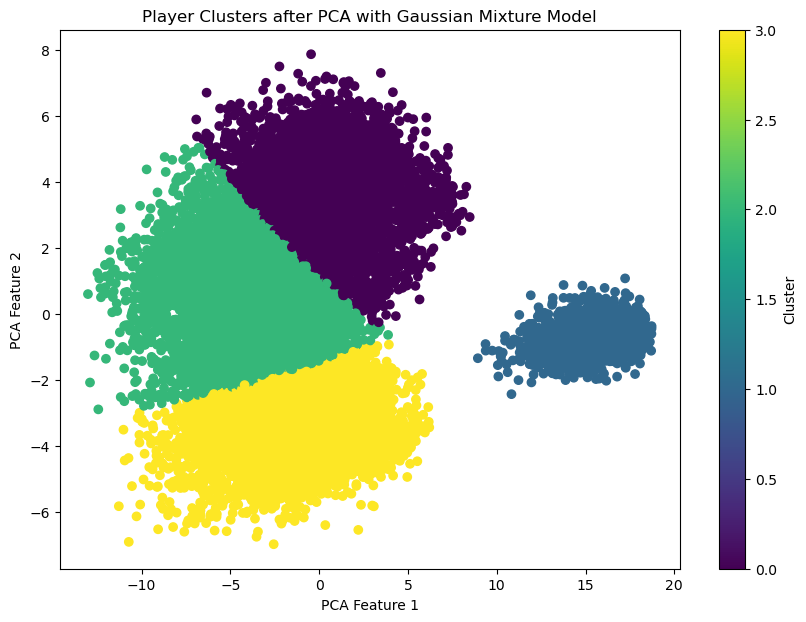

In [45]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.mixture import GaussianMixture



# Selecting relevant features for clustering
features = [
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision',
        'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb', 'gk']

X = male_players_24[features]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)  # Adjust based on your needs
X_pca = pca.fit_transform(X_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_pca)
kmeans_predict = kmeans.predict(X_pca)

# Adding cluster labels to the original dataframe
male_players_24['kmeans_cluster'] = kmeans.labels_

# Evaluating the clustering
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('Player Clusters after PCA')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar()
plt.show()

# Initialize the Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)

# Fit the GMM model to the PCA-transformed data
gmm.fit(X_pca)

# Predict the cluster labels
gmm_labels = gmm.predict(X_pca)

# Adding cluster labels to the original dataframe
male_players_24['gmm_cluster'] = gmm_labels

# Plotting the GMM clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title('Player Clusters after PCA with Gaussian Mixture Model')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()


In [32]:
# Define broad categories
defender_positions = {'CB', 'LB', 'RB', 'LWB', 'RWB', 'DB'}
midfielder_positions = {'CM', 'CAM', 'CDM', 'LM', 'RM'}
forward_positions = {'CF', 'ST', 'LW', 'RW'}
goalkeeper_position = {'GK'}

In [54]:
def categorize_and_check(position):
    # Split positions and remove spaces
    positions = position.replace(' ', '').split(',')
    for pos in positions:
        if pos in goalkeeper_position:
            return 'GK'
        elif pos in defender_positions:
            return 'D'
        elif pos in midfielder_positions:
            return 'M'
        elif pos in forward_positions:
            return 'F'
    return 'Unknown'

In [55]:
# Apply function to player positions
male_players_24['broad_position'] = male_players_24['player_positions'].apply(categorize_and_check)

male_players_24['broad_position'].unique()

array(['F', 'M', 'GK', 'D'], dtype=object)

In [57]:
male_players_24.groupby('broad_position')['player_id'].count()

broad_position
D     6174
F     3458
GK    2045
M     6673
Name: player_id, dtype: int64

In [58]:
attributes=['lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram']

# Melting the DataFrame to have attribute names in a single column and their values in another
melted_df = male_players_24.melt(id_vars=['broad_position'], value_vars=attributes, var_name='Attribute', value_name='Value')
melted_df

,broad_position,Attribute,Value
0,F,lw,91
1,F,lw,82
2,M,lw,87
3,F,lw,90
4,F,lw,86
...,...,...,...
146795,D,ram,28
146796,D,ram,33
146797,F,ram,45
146798,M,ram,47


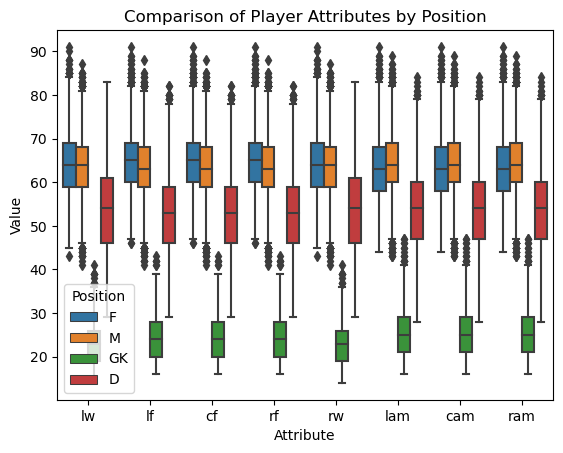

In [59]:
sns.boxplot(data=melted_df, x='Attribute', y='Value', hue='broad_position')
plt.title('Comparison of Player Attributes by Position')
plt.xlabel('Attribute')
plt.ylabel('Value')
plt.legend(title='Position')
plt.show()

In [60]:
# Calculating the correlation matrix
corr_matrix = male_players_24[attributes].corr()
corr_matrix

,lw,lf,cf,rf,rw,lam,cam,ram
lw,1.000000,0.994407,0.994407,0.994407,1.000000,0.992693,0.992693,0.992693
lf,0.994407,1.000000,1.000000,1.000000,0.994407,0.994642,0.994642,0.994642
cf,0.994407,1.000000,1.000000,1.000000,0.994407,0.994642,0.994642,0.994642
rf,0.994407,1.000000,1.000000,1.000000,0.994407,0.994642,0.994642,0.994642
rw,1.000000,0.994407,0.994407,0.994407,1.000000,0.992693,0.992693,0.992693
lam,0.992693,0.994642,0.994642,0.994642,0.992693,1.000000,1.000000,1.000000
cam,0.992693,0.994642,0.994642,0.994642,0.992693,1.000000,1.000000,1.000000
ram,0.992693,0.994642,0.994642,0.994642,0.992693,1.000000,1.000000,1.000000


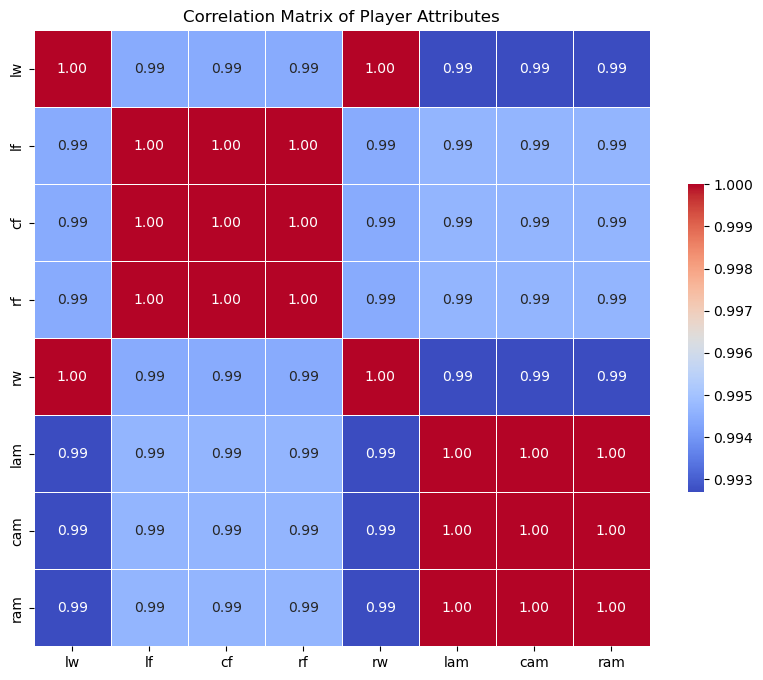

In [61]:
# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Player Attributes')
plt.show()

In [64]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import rand_score

ari = adjusted_rand_score(male_players_24['broad_position'], gmm_labels)
ri = rand_score(male_players_24['broad_position'], gmm_labels)
print(f'Adjusted Rand Index (ARI): {ari}')
print(f'Rand Index (RI): {ri}')

Adjusted Rand Index (ARI): 0.40231167914161486
Rand Index (RI): 0.7547793871860504


In [65]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import rand_score

ari = adjusted_rand_score(male_players_24['broad_position'], kmeans_predict)
ri = rand_score(male_players_24['broad_position'], kmeans_predict)
print(f'Adjusted Rand Index (ARI): {ari}')
print(f'Rand Index (RI): {ri}')

NameError: name 'kmeans_predict' is not defined